In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as md
from tqdm import trange

from utils.trading_model import *
from utils.experiment_utils import *
from cvx.covariance.ewma import iterated_ewma, _ewma_cov, _ewma_mean
from cvx.covariance.combination import from_sigmas
sns.set()
sns.set(font_scale=1.5)

%load_ext autoreload
%autoreload 2


# Import data

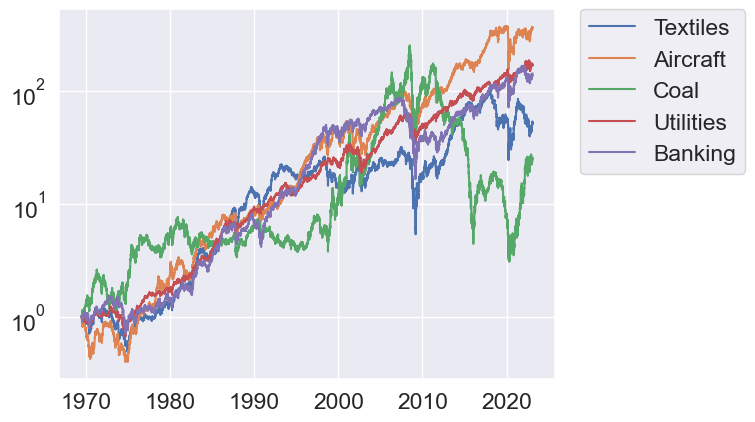

In [2]:
returns = pd.read_csv('data/49_industries.csv', index_col=0, parse_dates=True)

# Risk-free rate
FF = pd.read_csv('data/ff5.csv', index_col=0, parse_dates=True)
rf_rate = pd.DataFrame(FF.loc[:,"RF"])
rf_rate.index = pd.to_datetime(rf_rate.index, format='%Y%m%d')

columns = ["Txtls", "Aero", "Coal", "Util", "Banks"]
labels = ["Textiles", "Aircraft", "Coal", "Utilities", "Banking"]
plt.plot((returns[columns]+1).cumprod(axis=0), label=labels)
# fix legend
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);
plt.yscale("log");

# Covariance predictors

In [3]:
### Parameters
rw_memory = 500
ewma_halflife=250
iewma_pair = (125,250)
cm_iewma_pairs = [(21, 63), (63, 125), (125, 250), (250, 500), (500, 1000)]

In [4]:
# Rolling window 
rw = rolling_window(returns, rw_memory) 

In [5]:
# EWMA
ewma = dict(_ewma_cov(returns, halflife=ewma_halflife))

In [6]:
# IEWMA  
iewma = list(iterated_ewma(returns, vola_halflife=iewma_pair[0], cov_halflife=iewma_pair[1]))
iewma = {iterate.time: iterate.covariance for iterate in iewma}

Next we import the precomputed MGARCH predictors (computed using the rmgarch
package in R). We used the first 250 days for training. Hence the first
predictors is given at day 250, and predicts the covariance matrix for day 251.
(Python uses zero-based indexing, so the first predictor will have time index 249.)

In [7]:
# MGARCH precomputed in R due to computational complexity
# The covariance matrices were computed for 100*r for numerical reasons 

mgarch_cond_cov_split = [];
n_chunks = 15
for i in range(n_chunks):
    mgarch_cond_cov_split.append(pd.read_csv("mgarch_predictors_from_R/49_industries/mgarch_49_industries_{}.csv".format(i+1), index_col=0))
mgarch_cond_cov = pd.concat(mgarch_cond_cov_split)

Sigmas = from_row_matrix_to_covariance(mgarch_cond_cov.values, returns.shape[1]) / 10000

# Remove first year since it was used for training
times = returns.index[249:] 
mgarch = {times[t]: pd.DataFrame(Sigmas[t], index=returns.columns, columns=returns.columns) for t in range(Sigmas.shape[0])}

In [8]:
# CM-IEWMA
iewmas = {f"{pair[0]}-{pair[1]}": list(iterated_ewma(returns, vola_halflife=pair[0], cov_halflife=pair[1], min_periods_vola=63, min_periods_cov=63)) for pair in cm_iewma_pairs}
Sigmas = {key: {item.time: item.covariance for item in iewma} for key, iewma in iewmas.items()}

# Regularize the first covariance matrix
fast = cm_iewma_pairs[0]; fast = f"{fast[0]}-{fast[1]}"
Sigmas[fast] = add_to_diagonal(Sigmas[fast], lamda=0.05)

results = list(from_sigmas(Sigmas, returns, means=None).solve(window=10, solver="ECOS"))

cm_iewma = {result.time: result.covariance for result in results}
weights = {result.time: result.weights for result in results}

In [9]:
# Prescient 
prescient = {}
for t in returns.index:
    # get sample covariance matrix for corresponding quarter
    quarter = (t.month-1)//3 + 1
    cov = np.cov(returns.loc[(returns.index.year == t.year) & (returns.index.quarter == quarter)].values, rowvar=False)
    mean = np.mean(returns.loc[(returns.index.year == t.year) & (returns.index.quarter == quarter)].values, axis=0)
    prescient[t] = pd.DataFrame(cov+np.outer(mean, mean), index=returns.columns, columns=returns.columns)

# Define end and start dates for backtests

In [10]:
# Define start and end of backtest; first two years used for training/burn-in
start_date = pd.to_datetime("1971-06-24", format="%Y-%m-%d")
end_date = pd.to_datetime("2022-12-30", format="%Y-%m-%d")

In [11]:
names = ["RW", "EWMA", "IEWMA", "MGARCH", "CM-IEWMA", "PRESCIENT"]
predictors_temp = [rw, ewma, iewma, mgarch, cm_iewma, prescient]
predictors = []

for predictor in predictors_temp:
    predictors.append({t: predictor[t] for t in predictor.keys() if t >= start_date and t <= end_date})

# CM-IEWMA component weights

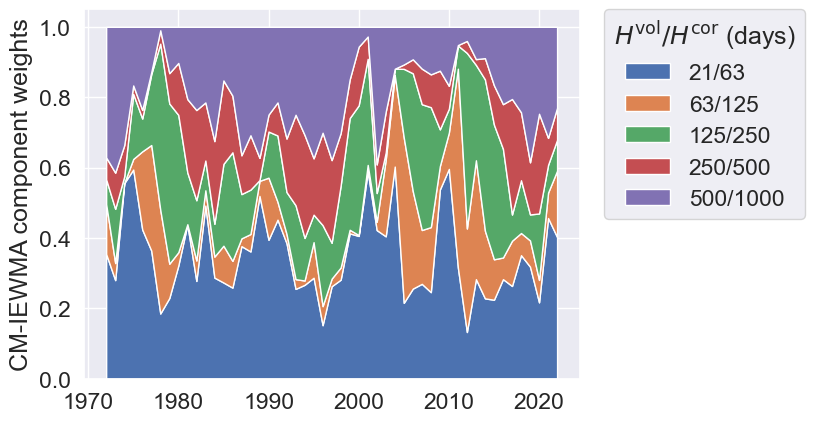

In [12]:
yearly_weights  = pd.DataFrame(weights).T.resample("Y").mean().loc[start_date:end_date]

plt.stackplot(yearly_weights.index, yearly_weights.values.T, labels=[f"{pair[0]}/{pair[1]}" for pair in cm_iewma_pairs])
plt.ylabel("CM-IEWMA component weights")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., title=r"$H^{\mathrm{vol}}/H^{\mathrm{cor}}$ (days)");

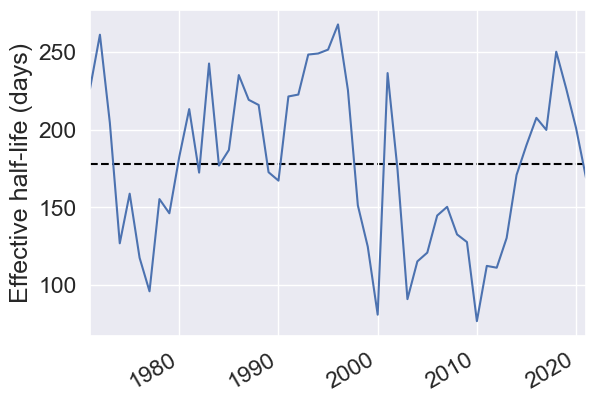

In [13]:
halflifes_vola = np.array([cm_iewma_pairs[i][0] for i in range(len(cm_iewma_pairs))])
(yearly_weights * halflifes_vola).sum(axis=1).plot()
plt.axhline((yearly_weights * halflifes_vola).sum(axis=1).mean(), color="black", linestyle="--", label="Mean half-life", zorder=-1);
plt.ylabel("Effective half-life (days)")
plt.gcf().autofmt_xdate()

# MSEs

In [14]:
for i, predictior in enumerate(predictors):
    MSE_temp = MSE(returns, predictior).resample("Q").mean()

    print("\n" + names[i])
    print(f"mean: {MSE_temp.mean():.6f}")
    print(f"std: {MSE_temp.std():.6f}")
    print(f"max: {MSE_temp.max():.6f}")
    


RW
mean: 0.000761
std: 0.004010
max: 0.038929

EWMA
mean: 0.000747
std: 0.003991
max: 0.038876

IEWMA
mean: 0.000737
std: 0.003933
max: 0.038740

MGARCH
mean: 0.000675
std: 0.003579
max: 0.037699

CM-IEWMA
mean: 0.000694
std: 0.003697
max: 0.037869

PRESCIENT
mean: 0.000658
std: 0.003505
max: 0.036677


In [16]:
for i, predictior in enumerate(predictors):
    MSE_temp = MSE(returns, predictior).resample("Q").mean()

    print("\n" + names[i])
    print(f"mean: {MSE_temp.mean():.6f}")
    print(f"std: {MSE_temp.std():.6f}")
    print(f"max: {MSE_temp.max():.6f}")
    


RW
mean: 0.000761
std: 0.004010
max: 0.038929

EWMA
mean: 0.000747
std: 0.003991
max: 0.038876

IEWMA
mean: 0.000737
std: 0.003933
max: 0.038740

CM-IEWMA
mean: 0.000685
std: 0.003635
max: 0.038102

MGARCH
mean: 0.000675
std: 0.003579
max: 0.037699

Prescient
mean: 0.000658
std: 0.003505
max: 0.036677


# Log likelihoods

In [15]:
log_likelihoods = {}

for i, predictor in enumerate(predictors):
    print("Computing " + names[i] + " log-likelihood...")
    returns_temp = returns.loc[pd.Series(predictor).index].values[1:]
    times = pd.Series(predictor).index[1:]
    Sigmas_temp = np.stack([predictor[t].values for t in predictor.keys()])[:-1]

    log_likelihoods[names[i]] = pd.Series(log_likelihood(returns_temp, Sigmas_temp), index=times)

regrets = {}
for name in log_likelihoods:
    regrets[name] =  log_likelihoods["PRESCIENT"] - log_likelihoods[name]

Computing RW log-likelihood...
Computing EWMA log-likelihood...
Computing IEWMA log-likelihood...
Computing MGARCH log-likelihood...
Computing CM-IEWMA log-likelihood...
Computing PRESCIENT log-likelihood...


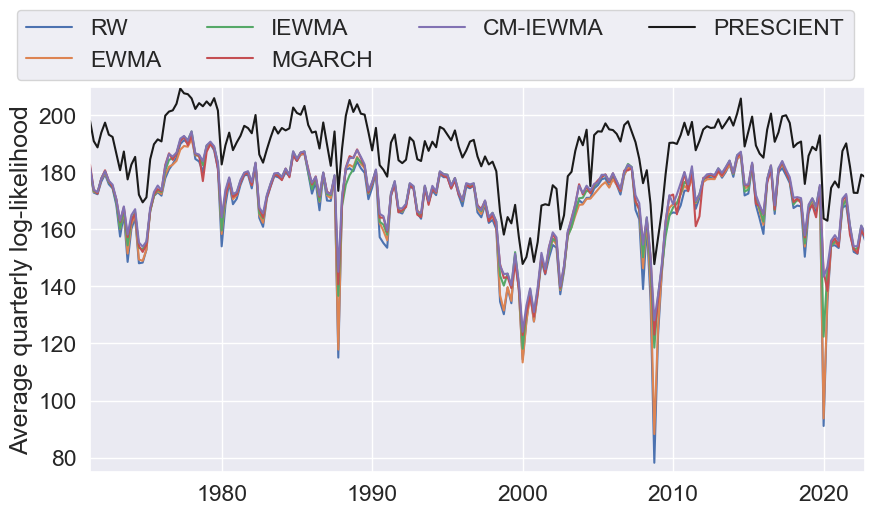

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
for name in names:
    if name == 'PRESCIENT':
        log_likelihoods[name].resample("Q").mean().plot(label=name, c="k")
    else:
        log_likelihoods[name].resample("Q").mean().plot(label=name)
plt.legend(bbox_to_anchor=(1, 1.23), loc='upper right', ncols=4, labels=names, scatterpoints=1, markerscale=5);
plt.ylabel("Average quarterly log-likelihood")
plt.ylim(75,210);

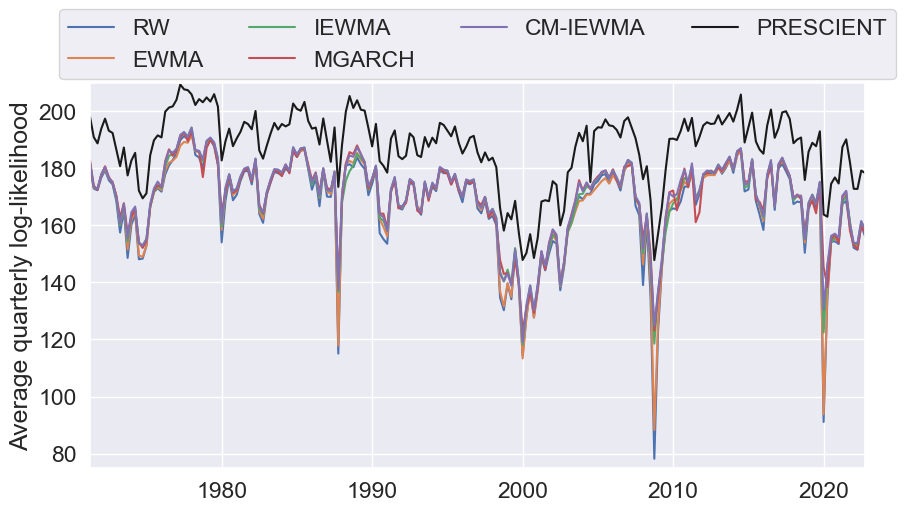

In [87]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
for name in names:
    if name == 'PRESCIENT':
        log_likelihoods[name].resample("Q").mean().plot(label=name, c="k")
    else:
        log_likelihoods[name].resample("Q").mean().plot(label=name)
plt.legend(bbox_to_anchor=(0.5, 1.1), loc='center', ncols=4, labels=names, scatterpoints=1, markerscale=5, );
plt.ylabel("Average quarterly log-likelihood")
plt.ylim(75,210);

# Regrets

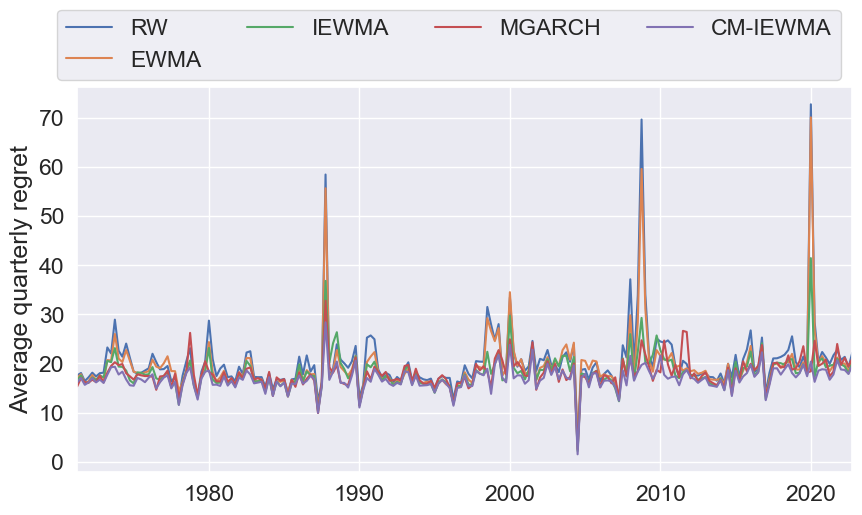

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
for name in names:
    if name == 'PRESCIENT':
        pass
    else:
        regrets[name].resample("Q").mean().plot(label=name)
plt.legend(bbox_to_anchor=(1, 1.23), loc='upper right', ncols=4, labels=names[:-1], scatterpoints=1, markerscale=5);
plt.ylabel("Average quarterly regret");
# plt.ylim(5,75);


### Compare CM-IEWMA with MGARCH

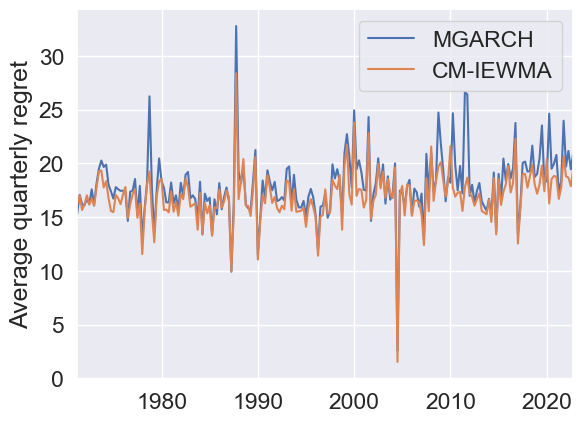

In [19]:
regret_mgarch = regrets["MGARCH"].resample("Q").mean()
regret_cm_iewma = regrets["CM-IEWMA"].resample("Q").mean()

regret_mgarch.plot(label="MGARCH")
regret_cm_iewma.plot(label="CM-IEWMA");
plt.ylabel("Average quarterly regret")
plt.legend();

In [20]:
cm_iewma_advantage = (regret_cm_iewma - regret_mgarch < 0).mean()
print(f"CM-IEWMA is better than MGARCH {cm_iewma_advantage:.0%} of the time")

CM-IEWMA is better than MGARCH 87% of the time


### Regret CDF plots

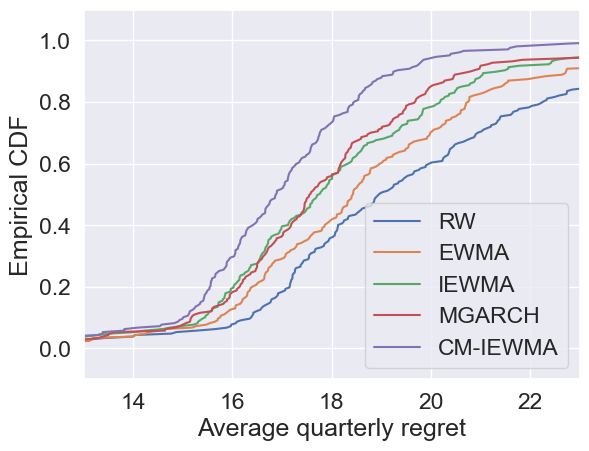

In [21]:
for name in log_likelihoods:
    if name != "PRESCIENT":
        data = regrets[name].resample("Q").mean().values
        x, y = ecdf(data)
        plt.plot(x, y, label=name)
plt.xlim(13,23)
plt.ylim(-0.1,1.1)
plt.xlabel("Average quarterly regret")
plt.ylabel("Empirical CDF")
plt.legend();

### Regret metrics

In [22]:
print("\\begin{tabular}{lccccc}")
print("   \\toprule")
print("   Predictor & Average & Std.~dev. & Max \\\\")
print("   \\midrule")

for name in regrets:
    if name != "PRESCIENT":
        print("   {}".format(name), end=" & ")
        regret = regrets[name].resample("Q").mean()
        metrics = (np.mean(regret).round(1), np.std(regret).round(1), np.max(regret).round(1))
        print("{} & {} & {} \\\\".format(metrics[0], metrics[1], metrics[2]))

print("   \\hline")
print("   PRESCIENT & 0.0 & 0.0 & 0.0 \\\\")
print("   \\bottomrule")
print("\\end{tabular}")


\begin{tabular}{lccccc}
   \toprule
   Predictor & Average & Std.~dev. & Max \\
   \midrule
   RW & 20.4 & 6.9 & 72.8 \\
   EWMA & 19.4 & 6.2 & 70.1 \\
   IEWMA & 18.2 & 3.6 & 41.4 \\
   MGARCH & 17.9 & 3.0 & 32.8 \\
   CM-IEWMA & 16.9 & 2.4 & 28.4 \\
   \hline
   PRESCIENT & 0.0 & 0.0 & 0.0 \\
   \bottomrule
\end{tabular}


# Portfolio optimization

In [13]:
from cvx.backtest.portfolios import *

# Risk-free rate for backtest period; for cash allocation end_date removed since
# it is removed in returns (in shift(-1)) to make predictors causal
rf = rf_rate.loc[start_date:end_date].iloc[:-1]

# Portfolio paramaters
additonal_cons = {"short_lim":1.6, "upper_bound":0.15,\
             "lower_bound":-0.1}
sigma_tar = 0.05
excess = True

### Equally weighted

In [24]:
traders_eq_w = EqWeighted(returns, predictors, names, start_date, end_date).backtest()

100%|██████████| 6/6 [00:29<00:00,  4.90s/it]


In [26]:
create_table(traders_eq_w, sigma_tar, rf, excess, prescient=False)

\begin{tabular}{lcccc}
   \toprule
   {Predictor} & {Return} & {Risk} & {Sharpe} & {Drawdown} \\
   \midrule
   RW & 2.2\% & 5.4\% & 0.4 & 16\% \\
   EWMA & 2.2\% & 5.1\% & 0.4 & 15\% \\
   IEWMA & 2.2\% & 5.1\% & 0.4 & 15\% \\
   MGARCH & 2.4\% & 5.1\% & 0.5 & 14\% \\
   CM-IEWMA & 2.3\% & 5.0\% & 0.5 & 13\% \\
   \hline
   \bottomrule
\end{tabular}


### Minimum risk

In [27]:
traders_min_risk = MinRisk(returns, predictors, names, start_date, end_date).backtest(additonal_cons)

  0%|          | 0/6 [00:00<?, ?it/s]/Users/kasper/Documents/Stanford/Research/My papers/w_it_ewma/publicRepo/cov_pred_finance/.venv/lib/python3.9/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)
 17%|█▋        | 1/6 [01:40<08:22, 100.43s/it]/Users/kasper/Documents/Stanford/Research/My papers/w_it_ewma/publicRepo/cov_pred_finance/.venv/lib/python3.9/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS s

In [53]:
# From 2010
create_table(traders_min_risk, sigma_tar, rf, excess, prescient=False)

\begin{tabular}{lcccc}
   \toprule
   {Predictor} & {Return} & {Risk} & {Sharpe} & {Drawdown} \\
   \midrule
   RW & 3.1\% & 5.8\% & 0.5 & 23\% \\
   EWMA & 3.1\% & 5.4\% & 0.6 & 19\% \\
   IEWMA & 3.3\% & 5.5\% & 0.6 & 19\% \\
   MGARCH & 4.3\% & 6.1\% & 0.7 & 20\% \\
   CM-IEWMA & 3.5\% & 5.3\% & 0.7 & 20\% \\
   \hline
   \bottomrule
\end{tabular}


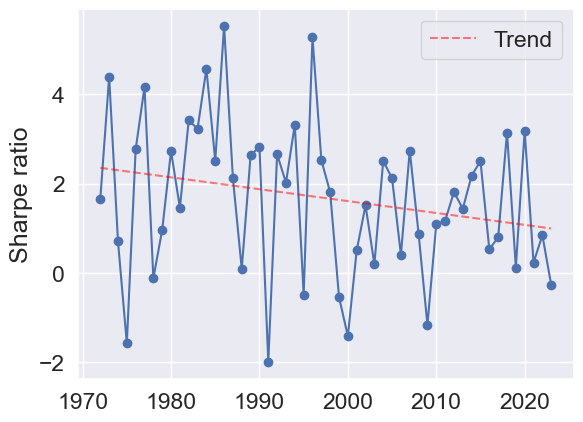

In [54]:
trader = traders_min_risk["CM-IEWMA"]
SRs = yearly_SR(trader)

### Maximum diversification 

In [55]:
traders_max_diverse = MaxDiverse(returns, predictors, names, start_date, end_date).backtest(additonal_cons)

100%|██████████| 6/6 [04:34<00:00, 45.72s/it]


In [56]:
create_table(traders_max_diverse, sigma_tar, rf, excess)

\begin{tabular}{lcccc}
   \toprule
   {Predictor} & {Return} & {Risk} & {Sharpe} & {Drawdown} \\
   \midrule
   RW & 2.1\% & 5.5\% & 0.4 & 16\% \\
   EWMA & 2.1\% & 5.1\% & 0.4 & 16\% \\
   IEWMA & 2.2\% & 5.2\% & 0.4 & 14\% \\
   MGARCH & 2.5\% & 5.1\% & 0.5 & 12\% \\
   CM-IEWMA & 2.3\% & 5.0\% & 0.5 & 12\% \\
   \hline
   PRESCIENT & 3.8\% & 5.0\% & 0.8 & 10\% \\
   \bottomrule
\end{tabular}


### Risk parity 

In [57]:
traders_risk_par = RiskParity(returns, predictors, names, start_date, end_date).backtest()

  0%|          | 0/6 [00:00<?, ?it/s]/Users/kasper/Documents/Stanford/Research/My papers/w_it_ewma/publicRepo/cov_pred_finance/.venv/lib/python3.9/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)
 17%|█▋        | 1/6 [07:21<36:49, 441.92s/it]/Users/kasper/Documents/Stanford/Research/My papers/w_it_ewma/publicRepo/cov_pred_finance/.venv/lib/python3.9/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS s

In [59]:
create_table(traders_risk_par, sigma_tar, rf, excess)

\begin{tabular}{lcccc}
   \toprule
   {Predictor} & {Return} & {Risk} & {Sharpe} & {Drawdown} \\
   \midrule
   RW & 2.4\% & 5.4\% & 0.5 & 16\% \\
   EWMA & 2.4\% & 5.1\% & 0.5 & 15\% \\
   IEWMA & 2.5\% & 5.1\% & 0.5 & 14\% \\
   MGARCH & 2.7\% & 5.1\% & 0.5 & 14\% \\
   CM-IEWMA & 2.5\% & 5.0\% & 0.5 & 13\% \\
   \hline
   PRESCIENT & 4.7\% & 4.9\% & 1.0 & 8\% \\
   \bottomrule
\end{tabular}


### Mean variance

In [14]:
def tune_returns(returns):
    """
    Cuts element in each row at its 40th and 60th percentile
    up and down
    """
    
    returns_tuned = np.zeros_like(returns)

    for t in range(returns.shape[0]):
        r_temp = returns.iloc[t]
        returns_tuned[t] = np.clip(r_temp, a_min=r_temp.quantile(0.4), a_max=r_temp.quantile(0.6))

    return pd.DataFrame(returns_tuned, index=returns.index, columns=returns.columns)

In [15]:
from experiments.utils.portfolio_backtests import MeanVariance

r_hat_ewma = pd.DataFrame(dict(_ewma_mean(returns, halflife=250))).T
r_hat_ewma = tune_returns(r_hat_ewma)

mean_predictors = [r_hat_ewma for name in names]

traders_mean_var = MeanVariance(returns, predictors, names, mean_predictors=mean_predictors, start_date=start_date, end_date=end_date).backtest(additonal_cons, sigma_tar)

100%|██████████| 6/6 [06:24<00:00, 64.16s/it]


In [16]:
create_table(traders_mean_var, None, rf, excess, prescient=True)

\begin{tabular}{lcccc}
   \toprule
   {Predictor} & {Return} & {Risk} & {Sharpe} & {Drawdown} \\
   \midrule
   RW & 5.6\% & 6.2\% & 0.9 & 16\% \\
   EWMA & 5.6\% & 5.8\% & 1.0 & 15\% \\
   IEWMA & 5.9\% & 5.7\% & 1.0 & 14\% \\
   MGARCH & 6.7\% & 6.4\% & 1.0 & 14\% \\
   CM-IEWMA & 6.1\% & 5.6\% & 1.1 & 13\% \\
   \hline
   PRESCIENT & 4.6\% & 5.0\% & 0.9 & 10\% \\
   \bottomrule
\end{tabular}


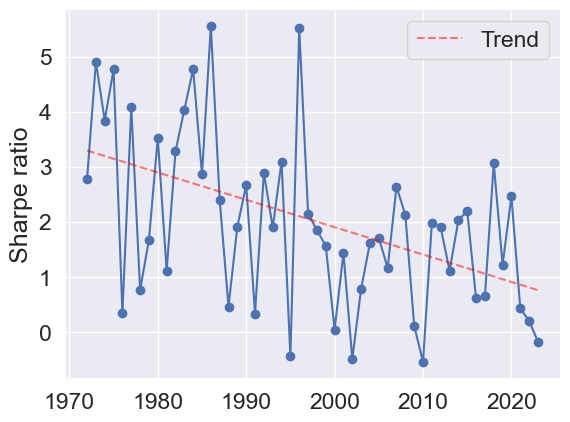

In [17]:
trader = traders_mean_var["CM-IEWMA"]
SRs = yearly_SR(trader)